# Introduction

The H-1B visa is a non-immigrant visa that allows US companies to employ foreign workers in speciality occupations. However, due to the difference in each states, the environment that every foreign worker would face might vary. This analysis aims to evaluate the H-1B visa application of each states to find out the best states for STEM employees. 

# Purpose 

* Verify the number of ranked Judo playerFind out the list of states that has most certified H-1B visa application 
* Check the list of states that has most certified H-1B visa application for STEM job 
* Identify the normalized salaries between the states by using cost of living index 


# Index

### 1. Data Gathering <br>
### 2. Data Cleaning
* Drop the missing values
* Replace the unnecessary values

### 3. Data Analyzing <br>

* Top 10 states that have most certified H-1B visa application
* Normalize the PREVAILING_WAGE and divide by the cost of living index
* Sort out the STEM job and compare the mean PREVAILING_WAGE_NORM_INDEX by states
* Plotting the number of STEM jobs by citis on the map

In [33]:
# import necessary libraries 

import pandas as pd
import numpy as np
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import math
import seaborn as sns

import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

from geopy.geocoders import Nominatim
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') 

## 1. Data Gathering


* H-1B visa data are derived from US Office of Foreign Labor Certification (OFLC) annual performance data. We will combine annual data from 2016 to 2020 into 1 CSV file.  

* Cost of Living Index data is downloadable from 'worldpopulationreview.com'

In [2]:
# listing file name

filenames = []
for i in range(16,21):
    f = ("H1B_"+str(i)+".csv")
    filenames.append(f)   

    
# listing columns needed

features = '''CASE_STATUS,DECISION_DATE,VISA_CLASS,JOB_TITLE,SOC_CODE,SOC_TITLE,EMPLOYER_NAME,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,PREVAILING_WAGE,PW_UNIT_OF_PAY'''
features = features.split(',')

In [3]:
# function to select columns in each CSV file

def h1b_col(name):
    s = pd.read_csv(name)
    s = s[features]
    return s


# concatenate files in the list

#combined_csv = pd.concat([h1b_col(f) for f in filenames ] )
#combined_csv.to_csv("H1B_5Y.csv") 
#combined_csv



In [19]:
# Import CSV file to Dataframe

df = pd.read_csv("H1B_5Y.csv")
df_col = pd.read_csv("col_wpr.csv")
df_geo = pd.read_csv("emp_city_geocodes.csv")
df_pop = pd.read_csv("nst-est2019-alldata.csv")
df = df.reset_index(drop=True)
df

,Unnamed: 0,CASE_STATUS,DECISION_DATE,VISA_CLASS,JOB_TITLE,SOC_CODE,SOC_TITLE,EMPLOYER_NAME,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,PREVAILING_WAGE,PW_UNIT_OF_PAY
0,0,CERTIFIED-WITHDRAWN,2015-10-16,H-1B,POSTDOCTORAL RESEARCH FELLOW,10-1021.00,BIOCHEMISTS AND BIOPHYSICISTS,UNIVERSITY OF MICHIGAN,ANN ARBOR,WASHTENAW,MI,48109,"41,000.00",Year,"36,067.00",Year
1,1,CERTIFIED-WITHDRAWN,2016-01-13,H-1B,CHIEF OPERATING OFFICER,11-1011,CHIEF EXECUTIVES,"GOODMAN NETWORKS, INC.",PLANO,COLLIN,TX,75093,"400,000.00",Year,"242,674.00",Year
2,2,CERTIFIED-WITHDRAWN,2015-12-10,H-1B,CHIEF PROCESS OFFICER,11-1011,CHIEF EXECUTIVES,"PORTS AMERICA GROUP, INC.",JERSEY CITY,HUDSON,NJ,07310,"264,000.00",Year,"193,066.00",Year
3,3,CERTIFIED-WITHDRAWN,2016-01-19,H-1B,"REGIONAL PRESIDEN, AMERICAS",11-1011,CHIEF EXECUTIVES,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",DENVER,DENVER,CO,80202,"220,314.00",Year,"220,314.00",Year
4,4,WITHDRAWN,2016-05-20,H-1B,PRESIDENT MONGOLIA AND INDIA,11-1011,CHIEF EXECUTIVES,PEABODY INVESTMENTS CORP.,ST. LOUIS,ST. LOUIS,MO,63101,171.63,Hour,75.73,Hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448746,473337,Withdrawn,2020-03-11,H-1B,CHIEF MARKETING OFFICER,11-2021,MARKETING MANAGERS,SWIM.AI INC.,SAN JOSE,SANTA CLARA,CA,95113,"$236,018.00",Year,NaN,NaN
3448747,473338,Withdrawn,2020-03-23,H-1B,PHYSICIAN (HOSPITALIST),29-1063,"INTERNISTS, GENERAL",MEMORIAL HOSPITAL OF LARAMIE COUNTY,CHEYENNE,LARAMIE,WY,82001,"$250,000.00",Year,NaN,NaN
3448748,473339,Withdrawn,2019-10-02,H-1B,"ASSISTANT PROFESSOR, INTERVENTIONAL CARDIOLOGI...",29-9099,"HEALTHCARE PRACTITIONERS AND TECHNICAL WORKERS,",RUSH UNIVERSITY MEDICAL CENTER,CHICAGO,COOK,IL,60612,"$285,000.00",Year,NaN,NaN
3448749,473340,Withdrawn,2019-10-04,H-1B,"CARDIOLOGIST, ASSISTANT PROF. & DIRECTOR",29-9099,"HEALTHCARE PRACTITIONERS AND TECHNICAL WORKERS,",RUSH UNIVERSITY MEDICAL CENTER,CHICAGO,COOK,IL,60612,"$285,000.00",Year,NaN,NaN


In [5]:
# Check the overview of the data

df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3448751 entries, 0 to 3448750
Data columns (total 16 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Unnamed: 0             int64 
 1   CASE_STATUS            object
 2   DECISION_DATE          object
 3   VISA_CLASS             object
 4   JOB_TITLE              object
 5   SOC_CODE               object
 6   SOC_TITLE              object
 7   EMPLOYER_NAME          object
 8   WORKSITE_CITY          object
 9   WORKSITE_COUNTY        object
 10  WORKSITE_STATE         object
 11  WORKSITE_POSTAL_CODE   object
 12  WAGE_RATE_OF_PAY_FROM  object
 13  WAGE_UNIT_OF_PAY       object
 14  PREVAILING_WAGE        object
 15  PW_UNIT_OF_PAY         object
dtypes: int64(1), object(15)
memory usage: 421.0+ MB


We can see that it has 3448751 of rows. <br> <br> 
  

## 2. Data Cleaning
  
<br>
   
* Features in 5 years of data are slightly different. Moreover, it has typo and inconsistent data. let's clean up!
<br>
<br>

In [6]:
# Drop the missing values

df.dropna(inplace = True)
df.isna( ).sum().sum()

0

In [7]:
# Cleaning the case status and leave Certified case only

df['CASE_STATUS'].str.lower().unique()
df['CASE_STATUS'] = df['CASE_STATUS'].str.lower()
df = df[df['CASE_STATUS'] == 'certified']


# Creating 'year' column from Decision date and cleaning the data

df["year"] = pd.to_datetime(df["DECISION_DATE"])
df["year"] = df["year"].dt.year
df["year"].head()
df = df[df['year'] > 2015]

# Replace the unnecessary dollar sign($) from Prevailing wage and change to float

df['PREVAILING_WAGE_Float'] = df['PREVAILING_WAGE'].astype('str').str.replace('$',"")
df['PREVAILING_WAGE_Float'] = df['PREVAILING_WAGE_Float'].str.replace(',',"").astype('float')
df['PREVAILING_WAGE_Float']


25             90.0
65         221541.0
66         198266.0
67         221541.0
68         187075.0
             ...   
3413704    345796.0
3413705    349200.0
3413706    380151.0
3413707    431637.0
3413708    760202.0
Name: PREVAILING_WAGE_Float, Length: 2640398, dtype: float64

<br>
WORKSTIE_STATE is mixture of original and abbreviation. We will use tha data from df_col to clean.
<br>

In [8]:
df['WORKSITE_STATE'].unique()

array(['CA', 'FL', 'GA', 'VA', 'PA', 'TX', 'MI', 'NY', 'IL', 'MD', 'MO',
       'OH', 'MA', 'NV', 'NC', 'DC', 'MN', 'AZ', 'WA', 'CO', 'TN', 'NJ',
       'MS', 'IN', 'UT', 'DE', 'VI', 'KS', 'WI', 'CT', 'MP', 'NE', 'GU',
       'OK', 'AR', 'KY', 'PR', 'HI', 'AK', 'SC', 'IA', 'WY', 'LA', 'NM',
       'WV', 'RI', 'SD', 'OR', 'ND', 'ME', 'AL', 'VT', 'NH', 'MT', 'ID',
       'MH', 'PW', 'FM', 'NEW YORK', 'CALIFORNIA', 'MARYLAND', 'ILLINOIS',
       'FLORIDA', 'OREGON', 'WASHINGTON', 'TEXAS', 'HAWAII', 'ARIZONA',
       'VIRGINIA', 'OHIO', 'GEORGIA', 'PENNSYLVANIA', 'CONNECTICUT',
       'DISTRICT OF COLUMBIA', 'NEW JERSEY', 'NORTH CAROLINA', 'UTAH',
       'DELAWARE', 'TENNESSEE', 'MICHIGAN', 'NEVADA', 'KENTUCKY',
       'MISSISSIPPI', 'MASSACHUSETTS', 'MINNESOTA', 'COLORADO', 'INDIANA',
       'KANSAS', 'NORTHERN MARIANA ISLANDS', 'WISCONSIN', 'IDAHO',
       'MISSOURI', 'LOUISIANA', 'PUERTO RICO', 'VIRGIN ISLANDS',
       'OKLAHOMA', 'SOUTH CAROLINA', 'ARKANSAS', 'IOWA', 'GUAM', 'ALASKA',


In [42]:
#Get the state name and code and change them into Dictionary

states = df_col[['state','state_code']]
states['state'] = states['state'].str.upper()
mydict = dict(zip(states.state, states.state_code))


# Replace original state name in to abbreviation

for long, short in mydict.items():
    df['WORKSITE_STATE'] = df['WORKSITE_STATE'].str.replace(long, short)


# Drop typos and unchanged values
    
df = df[df['WORKSITE_STATE'].str.len() == 2]


KeyboardInterrupt: 

<br>

## 3. Data Analysis
<br>

### a) Top 10 states that have most certified H-1B visa application

<br><br>

In [43]:
# California (CA), New york (NY) need to be replaced to CA and NY

df['WORKSITE_STATE'] = df['WORKSITE_STATE'].replace("CALIFORNIA","CA").replace("NEW YORK","NY")
df['WORKSITE_STATE'] = df['WORKSITE_STATE'].replace("New York","NEW YORK")
df_top10 = pd.DataFrame(df['WORKSITE_STATE'].value_counts().head(10)).reset_index()
df_top10.columns = ['WORKSITE_STATE','H1B COUNT']
df_top10



# Create the new column that shows H-1B visa per population of the each state
df_top10.insert(2, "POP_19", df_top10['WORKSITE_STATE'].map(df_pop.set_index('CODE')['POPESTIMATE2019']))
df_top10['H1B_PER_POP'] = df_top10['POP_19'] / df_top10['H1B COUNT']
df_top10



,WORKSITE_STATE,H1B COUNT,POP_19,H1B_PER_POP
0,CA,596794,39512223,66.207474
1,TX,313950,28995881,92.358277
2,NY,268340,19453561,72.495942
3,NJ,195655,8882190,45.397204
4,IL,154314,12671821,82.117118
5,WA,131611,7614893,57.859092
6,PA,109427,12801989,116.991136
7,GA,109382,10617423,97.067369
8,FL,101742,21477737,211.100008
9,MA,98948,6892503,69.657830


Text(0.5, 1.0, '')

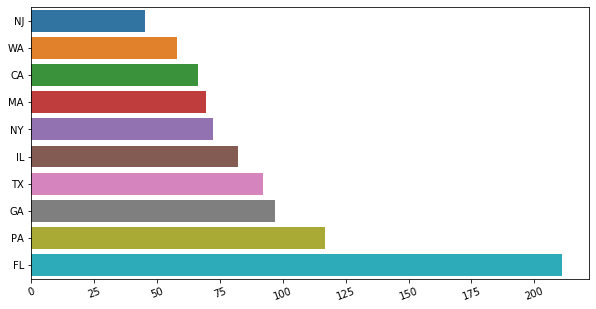

In [45]:
plt.figure(figsize=(10,5))
sns.barplot(x=df_top10['H1B_PER_POP'], y=df_top10['WORKSITE_STATE'], data = df_top10, order=df_top10.sort_values('H1B_PER_POP').WORKSITE_STATE)
plt.xticks(rotation=20)
plt.xlabel('')
plt.ylabel('')
plt.title('',fontdict = {'fontsize' : 15})

<br><br>
### b) Normalize the PREVAILING_WAGE and divide by the cost of living index
<br>

In [12]:
# Check the cases of PREVAILING_WAGE since 'hourly', 'Yearly','Weekly' data are mixed up

df['WAGE_UNIT_OF_PAY'].value_counts()

Year         2468012
Hour          165900
Month           1761
Week             664
Bi-Weekly        462
Name: WAGE_UNIT_OF_PAY, dtype: int64

In [13]:
# Map each unit into yearly data

salary_normalizer = {"Year":1, "Hour": 2080, "Month": 12, "Bi-Weekly": 24}
df["pw_normalizer"] = df["PW_UNIT_OF_PAY"].map(salary_normalizer)
df["PREVAILING_WAGE_NORM"] = df["PREVAILING_WAGE_Float"] * df["pw_normalizer"]
df["PREVAILING_WAGE_NORM"]


# Insert cost of living index according to the WORKSITE_STATE

df.insert(2, "COST_OF_LIVING_INDEX", df['WORKSITE_STATE'].map(df_col.set_index('state_code')['costIndex']))


# Divide PREVAILING_WAGE_NORM_INDEX by COST_OF_LIVING_INDEX to create PREVAILING_WAGE_NORM_INDEX

df["PREVAILING_WAGE_NORM_INDEX"] = df["PREVAILING_WAGE_NORM"] / df["COST_OF_LIVING_INDEX"]
df.dropna(inplace = True)
df["PREVAILING_WAGE_NORM_INDEX"]

25         1234.014502
65         2262.931563
66         2222.713004
67         2262.931563
68         1857.745780
              ...     
3413704    3605.797706
3413705    3783.315276
3413706    3038.776978
3413707    4567.587302
3413708    5011.219512
Name: PREVAILING_WAGE_NORM_INDEX, Length: 2621944, dtype: float64

<br><br>
### C) Sort out the STEM job and compare the mean PREVAILING_WAGE_NORM_INDEX by states

* According to SOC_CODE from OFLC, below can be cassifited into STEM job

13-0000	Business and Financial Operations Occupations<br>
15-0000	Computer and Mathematical Occupations<br>
17-0000	Architecture and Engineering Occupations<br>
19-0000	Life, Physical, and Social Science Occupations<br>
29-0000	Healthcare Practitioners and Technical Occupations<br>
31-0000	Healthcare Support Occupations<br>
<br>

In [14]:
# Sort out STEM job only.

df_STEM = df[df['SOC_CODE'].str[:2] == ("13" or "15" or '17' or '19' or '29' or '31')]

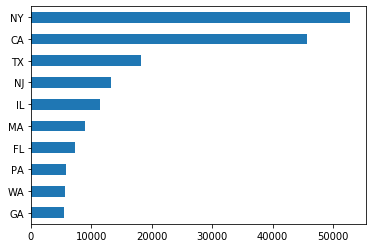

In [15]:
# The number of STEM job by states

df_STEM['WORKSITE_STATE'].value_counts().head(10).sort_values().plot(kind='barh')

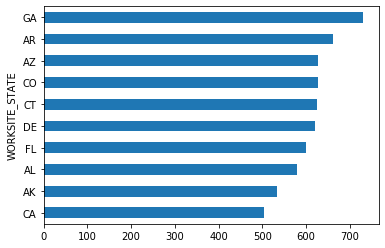

In [16]:
# List of the best mean normalized salary by states

df_STEM.groupby('WORKSITE_STATE').mean()['PREVAILING_WAGE_NORM_INDEX'].head(10).sort_values().plot(kind='barh')

<br>
* Features in 5 years of data are slightly different. Moreover, it has typo and inconsistent data. let's clean up!


<br><br>
### D) Plotting the number of STEM jobs by citis on the map
<br>

In [17]:
# Create the list contains longitute and Latituge of 
df_STEM_city = pd.DataFrame(df_STEM.groupby('WORKSITE_CITY')['WORKSITE_CITY'].count())
df_STEM_city.columns = ['WORKSITE_CITY_COUNT']
df_STEM_city.reset_index()
df_STEM_city = pd.merge(df_STEM_city, df_geo, how='left', left_on='WORKSITE_CITY', right_on='EMPLOYER_CITY')
cities = df_STEM_city[['lon','lat','WORKSITE_CITY_COUNT']].values.tolist()




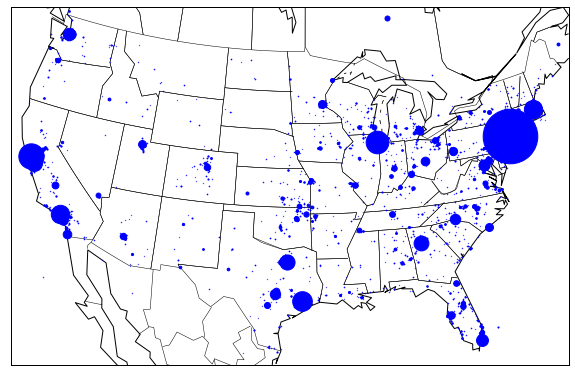

In [18]:
# draw tha map and plot the value

plt.figure(figsize=(10,10))
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)
map.drawmapboundary()
map.drawcoastlines()
map.drawstates()
map.drawcountries()


# Get the location of each city and plot it
for (lon,lat,count) in cities:
    x, y = map(lon, lat)
    map.plot(x,y,marker='o',color='blue', markersize=math.sqrt(count)*0.3)
plt.show()